# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru

**Описание проекта**

Сервис передает контакты клиента (ученика) репетитору.  
Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия.  
Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают.  
Некоторые репетиторы плохо договариваются о занятиях или обманывают.  
Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору.  
Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник,  
чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

Сейчас эта задача решается ручным просмотром сотрудниками или никак.

**Задачи:**
- Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий
  <br>будет классифицировать репетиторов на платящих и неэффективных.
- Оценка качества модели будет производиться с использованием метрики F1.


**Признаки обмана, выявленные при ручной проверке**

Заказчик произвел ручную проверку репетиторов на предмет мошенничества (звонки клиентам и так далее).  
Выяснилось, что 20% обманывают нас так или иначе.
- Несоответствие цены в заявке, в анкете репетитора и реальной
- 1 занятие на ученика (соотношение к общему кол-ву занятий)
- Разная стоимость с разными учениками
- Разная стоимость уроков с одним учеником
- Стоят занятия в расписании, а оплат нет
- Когда у репетитора по разным ученикам оплаты рядом по времени, то он сам оплачивает
- Как часто заходит в приложение - если редко, то сам оплачивает
- Статус заявки договорились о занятиях, оплат нет более недели (и не перенесено)
  - status в orders = 9
  - lessons с amount_payed > 0 за последнюю неделю
- Ученик не отмечен как завершенный, а оплат нет 
  - В качестве примера, есть SQL запрос позволяющий получить данную информацию
- Репетитор отчитался, что провёл платное занятие, оплаты нет 
  - В качестве примера, есть SQL запрос позволяющий получить данную информацию
- Цена ниже 500 р. в регионах, ниже 700 в мск


**Описание данных**

Информация о репетиторах (teacher_info.feather)

`id` - айди репетитора  
`reg_date` - дата регистрации  
`birth_date` - дата рождения  
`teaching_start_date` - дата начала первого занятия  
`is_email_confirmed` - подтвержден ли e-mail адресс  
`lesson_duration` - продолжит урока  
`lesson_cost` - стоимость урока  
`is_display` - показывается в каталоге  
`last_visited` - послеждний визит  
`is_pupils_needed` - открыт для заявок  
`is_cell_phone_confirmed` - подтвержден ли номер телефона  
`area_id` - регион  
`sex` - пол  
`orders_allowed` - разрешено назначать на заявки  
`review_num` - отзывы  


Статистика по репетиторам и таргет (teachers.feather)

`id` - айди репетитора  
`lessons_delivered` - поставлено уроков  
`mean_lesson_price` - средняя стоимость уроков  
`lessons_given` - оплачено уроков  
`lessons_started_fraction` - процент начала занятий  
`lessons_per_pupil` - занятий на ученика  
`money_recieved` - получено денег  
`blocked` - целевой признак (active/blocked)  

Ученики (lesson_course.feather)

`Id` - айди  
`client_id` - айди ученика  
`teacher_id` - айди репетитора  
`order_id` - айди заявки  
`lesson_place` - занятия онлайн или офлайн  
`lesson_price` - цена  
`is_active` - идут ли занятия, на паузе, завершены  
`lesson_duration` - продолжительность урока  
`date_updated`  
`suspend_till_date`  

Занятия (lessons.feather)

`Id` - айди  
`lesson_course_id` - айди ученика  
`lesson_date` - дата  
`time_from` - время от  
`time_to` - время до  
`home_task` - дз  
`is_regular` - автоматически повторяющееся занятие  
`amount_to_pay` - стоимость  
`amount_paid` - оплачено  

Цены на занятия репетиторов (teacher_prices.feather)

`date_update` - дата обновления цен  
`teacher_id` - айди репетитора  
`subject_id` - айди предмета  
`price` - цена занятий у себя  
`price_external` - цена занятий на выезде  
`price_remote` - цена онлайн занятий  

Заявки (orders.feather)

`order_date` - дата создания  
`subject_id` - предмет  
`purpose` - цель занятий  
`lesson_price` - цена  
`lesson_duration` - желаемая проодолжительность урока  
`home_metro_id` - ближайшее метро  
`add_info` - доп инфо  
`start_date`  
`working_teacher_id`  
`status_id` - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)  
`comments`  
`amount_to_pay`
`planned_lesson_number` - клиент планирует N занятий  
`first_lesson_date` - дата 1 занятия  
`creator_id` - кто создал заявку (id сотрудника или клиента)  
`pupil_category_new_id` - возраст ученика  
`lessons_per_week` - занятий а неделю  
`minimal_price`  
`teacher_sex` - пол репетитора  
`teacher_experience_from` - опыт репетитора от  
`teacher_experience_to` - опыт репетитора до  
`lesson_place_new` - онлайн, у ученика, у учителя  
`pupil_knowledgelvl` -уровень знаний ученика  
`teacher_age_from` - желаемый возраст репеитора от  
`teacher_age_to` - желаемый возраст репеитора от  
`chosen_teachers_only` - не предлагать репетиторов кроме выбранных самостоятельно  
`no_teachers_available` - на заявку нет подходящих репов  
`source_id` - где создана заявка (какая часть сайта, не регион)  
`original_order_id` - дублем какой заявки является эта заявка  
`client_id` - айди клиента  
`additional_status_id`  
`max_metro_distance` - максимально готов ехать от метро  
`estimated_fee`  
`payment_date`  
`test_group` - аб тесты  
`is_display_to_teachers` - хочет ли клиент получать отклики репетиторов

**Ход исследования**

- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков,
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей,
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

## Настройка рабочей среды

In [1]:
# !pip install pandas
# !pip install pyarrow
# !pip install phik
# !pip install seaborn
# !pip install catboost
# !pip install scikit-learn

In [2]:
import pandas as pd

# import seaborn as sns
# import matplotlib.pyplot as plt

Импорт исследовательского класса

In [3]:
from research_class import DatasetExplorer

Установка констант

In [4]:
RANDOM_STATE = 42

Пути к данным

In [5]:
teacher_prices_path = 'data/teacher_prices.feather'
teachers_info_path = 'data/teachers_info.feather'
lesson_course_path = 'data/lesson_course.feather'
teachers_path = 'data/teachers.feather'
lessons_path = 'data/lessons.feather'
orders_path = 'data/orders.feather'

## Загрузка данных

In [6]:
try:
    teacher_prices = pd.read_feather(teacher_prices_path)
    teachers_info = pd.read_feather(teachers_info_path)
    lesson_course = pd.read_feather(lesson_course_path)
    teachers = pd.read_feather(teachers_path)
    lessons = pd.read_feather(lessons_path)
    orders = pd.read_feather(orders_path)
    print('загружено из директории "data"')
except:
    teacher_prices = pd.read_feather(userdata.get('teacher_prices'))
    teachers_info = pd.read_feather(userdata.get('teachers_info'))
    lesson_course = pd.read_feather(userdata.get('lesson_course'))
    teachers = pd.read_feather(userdata.get('teachers'))
    lessons = pd.read_feather(userdata.get('lessons'))
    orders = pd.read_feather(userdata.get('orders'))
    print('загружено из директории Google Drive')

загружено из директории "data"


### teacher_prices

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


,date_update,teacher_id,subject_id,price,price_external,price_remote
143741,2015-10-13 16:14:16.867,95070.0,12,0,0,350
175282,2017-03-03 16:24:01.220,116378.0,1,0,0,0
56529,2012-05-01 15:54:54.340,38835.0,4,0,0,500
223291,2018-09-18 13:15:43.533,148606.0,8,0,1000,800
34333,2011-03-07 18:48:38.747,24398.0,3,1500,0,2000


количество полных дубликатов строк: 860


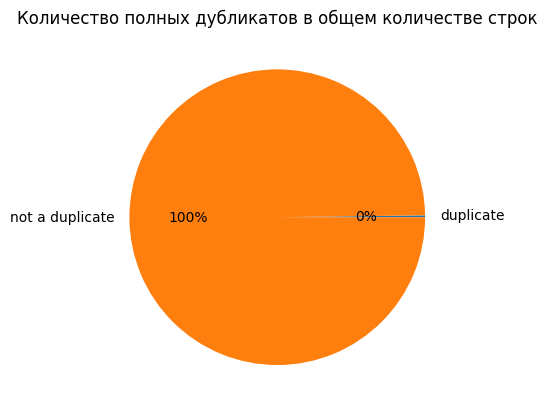

количество пропущенных значений:
date_update          0
teacher_id        4570
subject_id           0
price                0
price_external       0
price_remote         0
dtype: int64


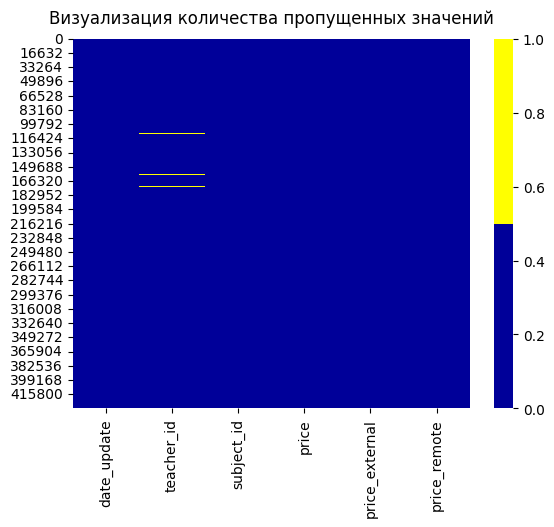

Процент пропущенных значений в признаках:
teacher_id: 1.06%
Количество уникальных значений в столбце 'teacher_id': 271396
Соотношение уникальных значений и общего количества записей в столбце 'teacher_id': 1.59

Количество уникальных значений в столбце 'subject_id': 27
Соотношение уникальных значений и общего количества записей в столбце 'subject_id': 16015.63



In [7]:
explorer_teacher_prices = DatasetExplorer(teacher_prices)
explorer_teacher_prices.explore_dataset()  # 432422

Точечное изучение нескольких пропущенных значений

In [8]:
# Получаем индексы пропущенных записей
missing_indices = teacher_prices[teacher_prices['teacher_id'].isna()].index

# Цикл для вывода окружения пропущенных индексов
for index in missing_indices[9:13]:
    print(f'Окружение пропущенной записи с индексом {index}:')
    display(teacher_prices.loc[index-2:index+2])

Окружение пропущенной записи с индексом 1950:


,date_update,teacher_id,subject_id,price,price_external,price_remote
1948,2008-09-21 16:08:45.620,1860.0,23,1000,1000,1000
1949,2008-09-21 16:12:48.057,1856.0,1,3500,4000,0
1950,2008-09-21 16:12:48.057,NaN,15,3000,4000,0
1951,2008-09-21 16:25:30.480,1861.0,8,0,0,2000
1952,2008-09-22 01:32:14.470,1374.0,6,750,750,750


Окружение пропущенной записи с индексом 2020:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2018,2008-09-24 17:29:59.240,602.0,6,500,500,500
2019,2008-09-24 17:31:57.660,615.0,33,2500,2500,2500
2020,2008-09-24 17:31:57.660,NaN,33,2500,2500,2500
2021,2008-09-24 17:31:57.660,615.0,23,2500,2500,2500
2022,2008-09-24 17:32:42.097,979.0,2,1500,1500,0


Окружение пропущенной записи с индексом 2493:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2491,2008-10-13 22:55:25.307,1761.0,2,700,0,0
2492,2008-10-13 22:55:46.883,354.0,2,0,450,0
2493,2008-10-13 22:55:46.883,NaN,1,0,450,0
2494,2008-10-13 23:02:10.443,2181.0,8,500,500,500
2495,2008-10-13 23:09:32.113,2147.0,2,1000,1000,1000


Окружение пропущенной записи с индексом 2736:


,date_update,teacher_id,subject_id,price,price_external,price_remote
2734,2008-10-23 22:48:04.080,2360.0,6,500,500,500
2735,2008-10-23 22:48:04.080,2360.0,2,500,500,500
2736,2008-10-23 22:56:19.877,NaN,2,1000,1000,1000
2737,2008-10-23 22:56:19.877,NaN,33,1000,1000,1000
2738,2008-10-23 22:59:47.717,2374.0,2,1500,1500,0


#### Выводы и заключения
- в признаке `date_update` необходимо изменить тип данных для корректного проведения дальнейших исследований;
- в признаке `teacher_id` также можно изменить тип данных для уменьшения объёма занимаемой памяти;
- обнаружены пропуски в `teacher_id`:
  - если пропущенные значения относятся к учителям выше или ниже по списку, то их можно заполнить;
  - ориентиром послужит точное совпадение в признаке `date_update`;
  - оставшиеся незаполненными записи будут исключены, т.к. объём датафрейма это позволяет;
- количество полных дубликатов записей составляет менее 1% от всего набора данных,  
  принимаю решение об их удалении;
- количество уникальных `teacher_id` в датафрейме - 271396, что примерно в полтора раза меньше общего количества записей,  
  это говорит о том, что некоторые преподаватели проводят обучение по нескольким предметам.

### teachers_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
200450,204861,2020-07-22 02:34:17.400,1999-09-20 00:00:00.000,2017-09-01 00:00:00.000,0,60,0,1,2020-07-22 02:34:39.793,NaN,0,2,1,1,0
133879,137274,2018-01-23 16:02:38.000,1994-10-26 00:00:00.000,2012-09-01 00:00:00.000,0,60,600,0,2022-09-26 09:59:53.243,NaN,0,4,1,1,0
5953,6233,2009-08-29 18:54:44.000,1986-08-06 00:00:00.000,2006-09-01 00:00:00.000,0,90,500,1,2013-10-23 04:21:29.000,1.0,0,1,2,0,1
242775,247389,2021-11-05 15:23:37.553,1993-04-25 00:00:00.000,2012-09-01 00:00:00.000,0,60,2500,1,2022-03-12 19:32:31.027,NaN,0,1,1,1,0
210058,214478,2020-10-08 09:29:27.043,2002-04-14 00:00:00.000,2020-09-01 00:00:00.000,0,60,0,0,None,NaN,0,17,2,1,0


количество полных дубликатов строк: 0
количество пропущенных значений:
id                              0
reg_date                        0
birth_date                      0
teaching_start_date             0
is_email_confirmed              0
lesson_duration                 0
lesson_cost                     0
is_display                      0
last_visited                72135
is_pupils_needed           296764
is_cell_phone_confirmed         0
area_id                         0
sex                             0
orders_allowed                  0
review_num                      0
dtype: int64


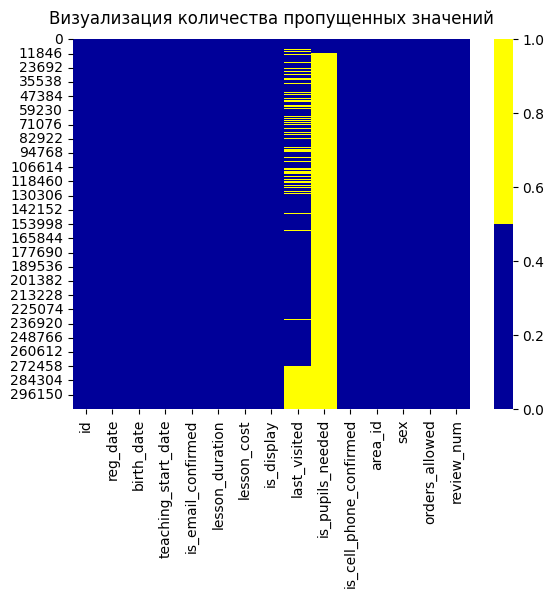

Процент пропущенных значений в признаках:
last_visited: 23.42%
is_pupils_needed: 96.36%
Количество уникальных значений в столбце 'id': 307972
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'area_id': 91
Соотношение уникальных значений и общего количества записей в столбце 'area_id': 3384.31



In [9]:
explorer_teachers_info = DatasetExplorer(teachers_info)
explorer_teachers_info.explore_dataset()  # 307972

#### Выводы и заключения
- для дальнейших исследований у данных признаков:
  <br>`reg_date`, `birth_date`, `teaching_start_date`, `last_visited` -
  <br>необходимо изменить тип данных на `datetime`;
- дубликатов строк в данных не обнаружено;
- в признаке `last_visited` почти четверть значений пропущена;
- в признаке `is_pupils_needed` пропущены почти все значения,
  <br>данный признак можно исключить из дальнейшего исследования;
- все `id` учителей в датафрейме уникальны

### lesson_course

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
88720,743211,801099.0,215516,1654890.0,4,600,1,60,2021-05-11 19:27:10.547,1800-01-01 00:00:00.000
757373,1433111,1193913.0,179940,2831762.0,3,900,0,60,2023-09-26 11:26:05.870,1800-01-01 00:00:00.000
549240,1256321,1082340.0,204581,2573414.0,4,900,1,60,2023-04-21 17:29:47.327,1800-01-01 00:00:00.000
591250,867931,850741.0,33337,1876088.0,6,2000,0,60,2021-12-01 15:09:51.540,1800-01-01 00:00:00.000
234475,900735,862311.0,140195,1937219.0,4,2000,0,60,2022-01-26 10:22:27.877,1800-01-01 00:00:00.000


количество полных дубликатов строк: 0
количество пропущенных значений:
id                      0
client_id               1
teacher_id              0
order_id             3306
lesson_place            0
lesson_price            0
is_active               0
lesson_duration         0
date_updated            0
suspend_till_date       0
dtype: int64


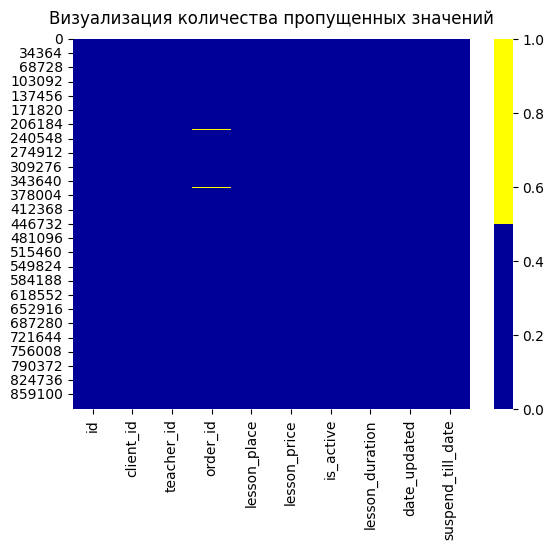

Процент пропущенных значений в признаках:
client_id: 0.00%
order_id: 0.37%
Количество уникальных значений в столбце 'id': 893438
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'client_id': 408319
Соотношение уникальных значений и общего количества записей в столбце 'client_id': 2.19

Количество уникальных значений в столбце 'teacher_id': 68187
Соотношение уникальных значений и общего количества записей в столбце 'teacher_id': 13.10

Количество уникальных значений в столбце 'order_id': 890129
Соотношение уникальных значений и общего количества записей в столбце 'order_id': 1.00



In [10]:
explorer_lesson_course = DatasetExplorer(lesson_course)
explorer_lesson_course.explore_dataset()  # 893438

#### Выводы и заключения
- пропуски в `client_id` и `order_id`, вероятно,
  <br>появились по причине ошибки и записи с ними необходимо исключить;
- дубликатов строк в датафрейме не обнаружено;
- у признаков `date_updated` и `suspend_till_date` нужно изменить тип данных на `datetime`

### teachers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
28,149380,780.0,1207.305476,694.0,0.435897,40.823529,837870.0,0
1320,83048,12.0,1458.333333,12.0,0.238095,2.400000,17500.0,1
1444,265740,13.0,1280.000000,10.0,0.285714,1.666667,12800.0,1
967,231410,90.0,932.142857,84.0,0.131579,5.600000,78300.0,1
623,258607,230.0,1253.475336,223.0,0.178295,9.695652,279525.0,1


количество полных дубликатов строк: 0
количество пропущенных значений:
id                          0
lessons_delivered           0
mean_lesson_price           0
lessons_given               0
lessons_started_fraction    0
lessons_per_pupil           0
money_recieved              0
blocked                     0
dtype: int64
Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'id': 1656
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Соотношение классов целевой переменной:
			blocked
1     557
0    1099
Name: count, dtype: int64


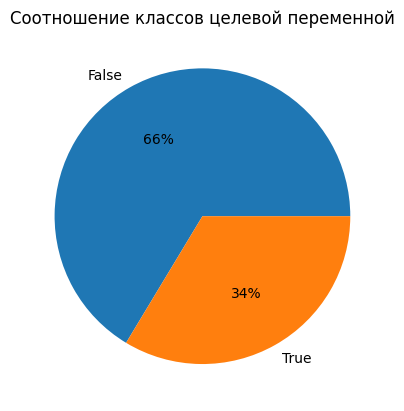

In [11]:
explorer_teachers = DatasetExplorer(teachers, target='blocked')
explorer_teachers.explore_dataset()

#### Выводы и заключения
- в датафрейме пропусков не обнаружено;
- дубликатов строк не обнаружено;
- все представленные `id` учителей уникальны;
- наблюдается дисбаланс классов целевой переменной.

### lessons

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
220027,2080388,770343,2021-12-23 00:00:00.000,19:00:00,20:00:00,NaN,0,1000.0,NaN
1098263,4164210,1487764,2023-10-27 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
742757,3183950,1126564,2023-03-25 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN
701017,3100849,652648,2022-11-30 00:00:00.000,21:00:00,22:00:00,NaN,0,NaN,NaN
114102,1881570,511087,2021-10-12 00:00:00.000,12:00:00,13:00:00,NaN,1,0.0,NaN


количество полных дубликатов строк: 0
количество пропущенных значений:
id                        0
lesson_course_id          0
lesson_date               0
time_from                 0
time_to                   0
home_task           1186158
is_regular                0
amount_to_pay        597751
amount_paid         1182984
dtype: int64


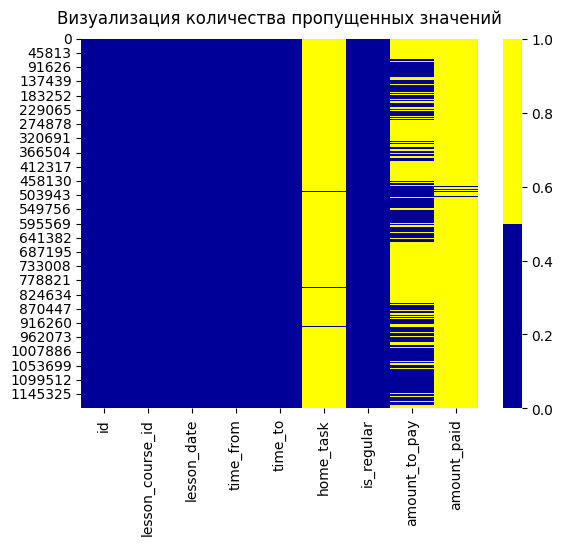

Процент пропущенных значений в признаках:
home_task: 99.58%
amount_to_pay: 50.18%
amount_paid: 99.32%
Количество уникальных значений в столбце 'id': 1191127
Соотношение уникальных значений и общего количества записей в столбце 'id': 1.00

Количество уникальных значений в столбце 'lesson_course_id': 203876
Соотношение уникальных значений и общего количества записей в столбце 'lesson_course_id': 5.84

Количество уникальных значений в столбце 'amount_paid': 61
Соотношение уникальных значений и общего количества записей в столбце 'amount_paid': 19526.67



In [12]:
explorer_lessons = DatasetExplorer(lessons)
explorer_lessons.explore_dataset()

#### Выводы и заключения
- дубликатов строк не обнаружено;
- в признаках `home_task` и `amount_paid` более 99% пропусков -
  <br>данные признаки будет исключены;
- все представленные `id` уроков уникальны.

### orders

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
25832,2613843,2023-05-25 15:49:11.087,12.0,Дополнения: ЕГЭ.\nКатегория ученика: школьник ...,2000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2023-05-25 15:49:31.897,...,0,0,14,2613718.0,1149352,NaN,NaN,7000,2023-06-19 15:32:41.073,1
70587,2549204,2023-03-29 07:25:08.460,9.0,Цели: углубленное изучение.\nКатегория ученика...,5000,60,None,1024.0,Количество занятий в неделю: 1-2.\nОпыт репети...,None,...,0,0,23,2549197.0,1123145,7.0,NaN,None,None,1
270133,2858145,2023-10-04 15:57:02.320,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,500,60,None,1556.0,Район: Майская горка округ.\nМесто проведения ...,2023-10-04 18:31:02.760,...,0,0,23,NaN,1240264,10.0,NaN,750,None,1
85309,1828721,2021-10-19 19:04:46.157,8.0,None,300,60,None,NaN,None,None,...,0,0,23,1828707.0,860988,7.0,NaN,None,None,1
405794,2249069,2022-10-10 12:56:22.613,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,600,60,None,491.0,Район: Нижегородский район.\nМесто проведения ...,2022-10-10 20:53:44.850,...,0,0,23,NaN,1008712,17.0,30.0,1710,None,1


количество полных дубликатов строк: 900


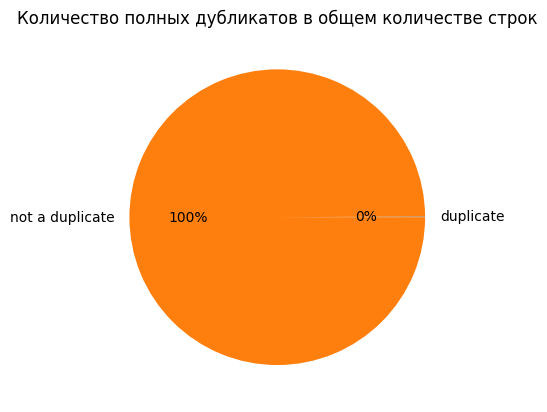

количество пропущенных значений:
id                               0
order_date                       0
subject_id                   10332
purpose                     166510
lesson_price                     0
lesson_duration                  0
lesson_place               1191830
home_metro_id               549414
add_info                    147173
start_date                  486283
working_teacher_id          485873
status_id                        0
comments                    850393
prefered_teacher_id        1191857
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1025290
creator_id                  612163
pupil_category_new_id       159391
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to        

In [ ]:
explorer_orders = DatasetExplorer(orders)
explorer_orders.explore_dataset()

#### Выводы и заключения
- количество полных дубликатов строк менее 1% - их можно удалить;

## Предобработка данных

### teacher_prices

Заполнение пропущенных значений

In [ ]:
for index, row in teacher_prices.iterrows():
    if pd.isnull(row['teacher_id']):
        # Генерируем "обрезанный" date_update для сравнения
        trimmed_date_update = row['date_update'][:-4]
        
        # Проверяем наличие совпадения признака date_update (обрезанного) выше и ниже
        prev_row = teacher_prices.iloc[index - 1] if index - 1 >= 0 else None
        next_row = teacher_prices.iloc[index + 1] if index + 1 < len(df) else None
        
        if prev_row is not None and prev_row['date_update'][:-4] == trimmed_date_update:
            teacher_prices.at[index, 'teacher_id'] = prev_row['teacher_id']
        elif next_row is not None and next_row['date_update'][:-4] == trimmed_date_update:
            teacher_prices.at[index, 'teacher_id'] = next_row['teacher_id']

teacher_prices.info()

In [ ]:
print(f"количество полных дубликатов строк: {teacher_prices.duplicated().sum()}")

sizes = [teacher_prices.duplicated().sum(), teacher_prices.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['duplicate', 'not a duplicate'], autopct='%1.0f%%')
plt.title('Количество полных дубликатов в общем количестве строк', size=12)
plt.show()

Удаление дубликатов

In [ ]:
teacher_prices.drop_duplicates(inplace=True)
teacher_prices.reset_index(drop=True, inplace=True)

In [ ]:
print(f"""количество пропущенных значений:
{teacher_prices.isna().sum()}""")

sizes = [teacher_prices['teacher_id'].isna().sum(), teacher_prices['teacher_id'].shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['missing values', 'not a missing values'], autopct='%1.0f%%')
plt.title('Количество полных пропусков в общем количестве строк', size=12)
plt.show()

Удаление оставшихся пропущенных значений

In [ ]:
teacher_prices.dropna(inplace=True)

Изменение типов данных

In [ ]:
teacher_prices['date_update'] = pd.to_datetime(teacher_prices['date_update'])
teacher_prices['teacher_id'] = teacher_prices['teacher_id'].astype('int')

In [ ]:
teacher_prices.info()
teacher_prices.head()

#### Выводы и заключения
- заполнены некоторые пропущенные значения `teacher_id` по совпадению признака `date_update`;
- количество дубликатов практически не изменилось после заполнения пропусков;
- дубликаты удалены;
- количество оставшихся пропусков около 1%;
- пропуски удалены

## EDA

### teacher_prices

## Разработка новых признаков

Отбор финального набора признаков для обучения

## Обучение моделей

## Оценка качества предсказания лучшей модели

Анализ важности признаков

## Заключение
Отчёт по выполненным в ходе исследования шагам

Сохранение зависимостей

In [15]:
# !pip freeze > requirements.txt